# `IMPORT LIBRARIES`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

sns.set()

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# `IMPORT DATASET`

In [3]:
power = pd.read_csv("Regrerssion_energy_production_data.csv", sep = ";")

In [4]:
power.head()

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
0,9.59,38.56,1017.01,60.10,481.30
1,12.04,42.34,1019.72,94.67,465.36
2,13.87,45.08,1024.42,81.69,465.48
3,13.72,54.30,1017.89,79.08,467.05
4,15.14,49.64,1023.78,75.00,463.58


# `EDA`

In [5]:
power.shape

(9568, 5)

In [6]:
power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        9568 non-null   float64
 1   exhaust_vacuum     9568 non-null   float64
 2   amb_pressure       9568 non-null   float64
 3   r_humidity         9568 non-null   float64
 4   energy_production  9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


no null values in any columns

In [7]:
power.duplicated().sum()

41

 41 duplicate instances

In [8]:
df =  power.copy()

In [9]:
df = df.drop_duplicates()

In [10]:
df.duplicated().sum()

0

duplicates have been dropped

In [11]:
df.describe()

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
count,9527.000000,9527.000000,9527.000000,9527.000000,9527.00000
mean,19.658225,54.293421,1013.237084,73.334951,454.33591
std,7.444397,12.686309,5.940526,14.607513,17.03908
min,1.810000,25.360000,992.890000,25.560000,420.26000
25%,13.530000,41.740000,1009.085000,63.375000,439.75000
50%,20.350000,52.080000,1012.920000,75.000000,451.52000
75%,25.710000,66.510000,1017.200000,84.850000,468.36500
max,37.110000,81.560000,1033.300000,100.160000,495.76000


after seeing the statisctics we cannot surely tell the distribution and if the outliers are present in the features or not. we will have to explore further

lets plot histogram, boxplot and qq plot of each feature to check its distribution

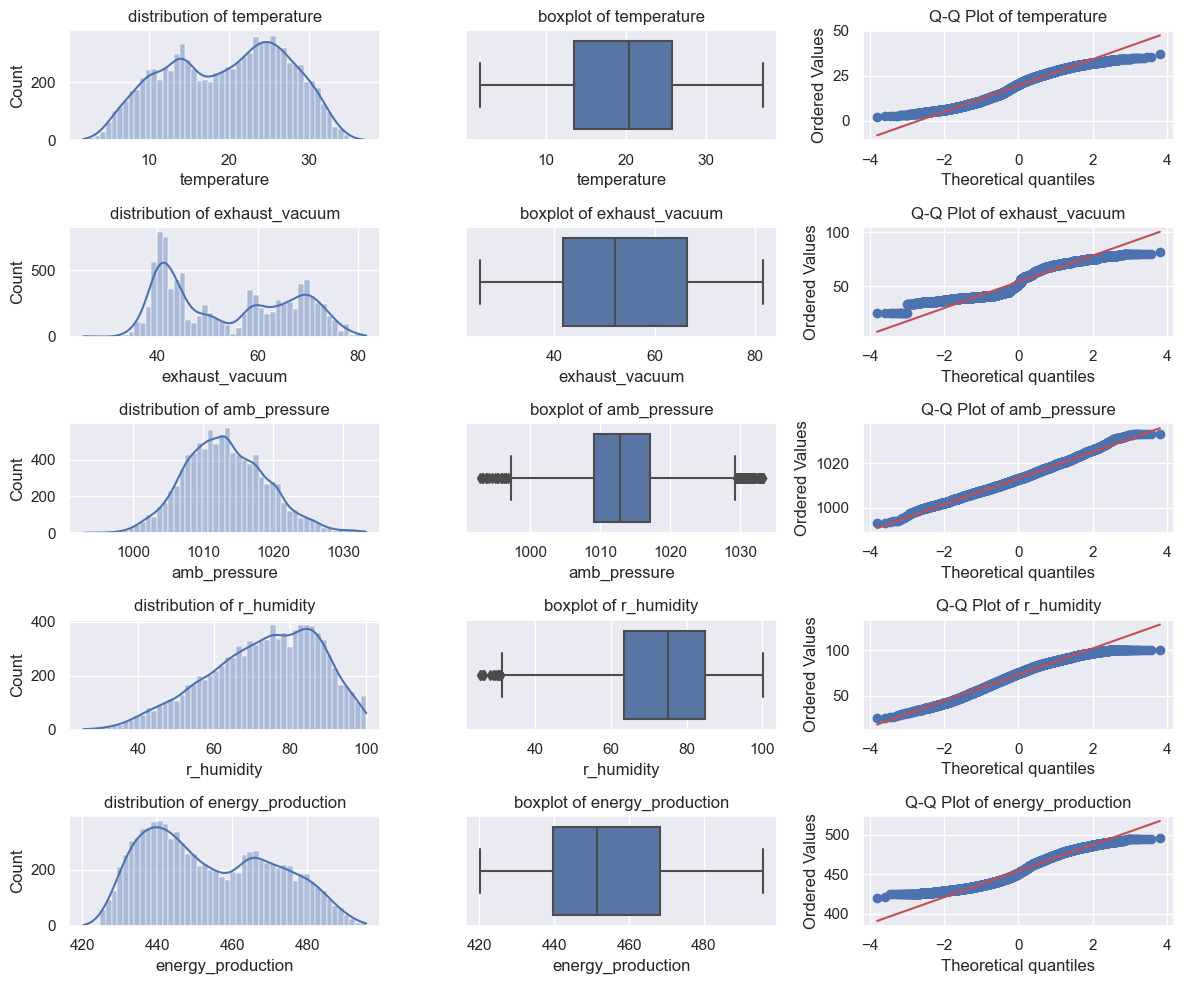

In [12]:
fig , ax = plt.subplots(5,3, figsize=(12,10), sharex =False, sharey =False)
for col_num ,col in enumerate(df.columns):
    sns.histplot( df[col] , ax = ax[col_num , 0], 
                 kde =True , bins = 50, alpha = 0.4, edgecolor = None)
    ax[col_num, 0].set_title(f"distribution of {col}")
    
    sns.boxplot(x = df[col] , ax = ax[col_num , 1])
    ax[col_num, 1].set_title(f"boxplot of {col}")
    
    probplot(df[col], plot=ax[col_num, 2], fit=True)
    ax[col_num, 2].set_title(f"Q-Q Plot of {col}")

plt.tight_layout()

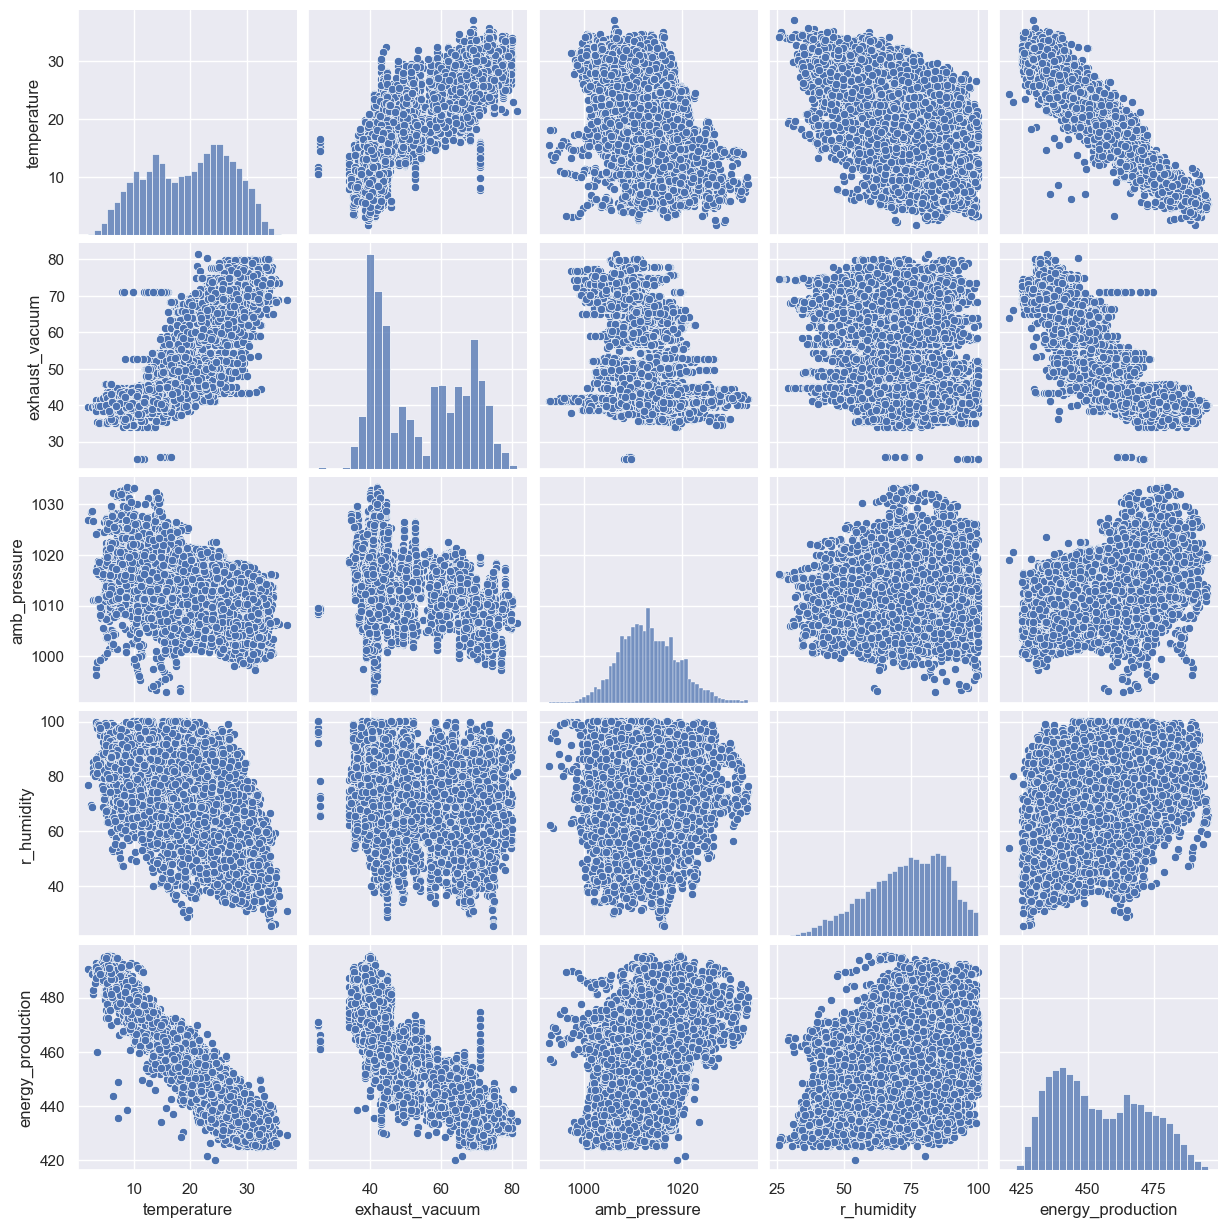

In [13]:
sns.pairplot(df)

<Axes: >

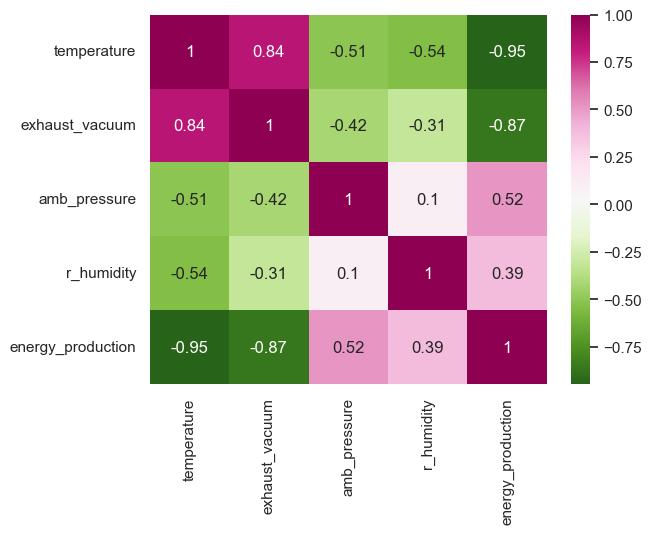

In [14]:
sns.heatmap(df.corr(), annot=True, cmap ='PiYG_r')

first we will pass the dataset without handiling the outliers, transforming columns, doing feature engineering to different models

# `MODEL BUILDING AND EVALUATION ON RAW DATASET`

In [15]:

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split , cross_val_score

In [16]:

X = df.drop("energy_production", axis = 1)
y = df['energy_production']

In [17]:

def evaluate_regression_models(X, y, models):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    
    scaling_methods = ['Standard Scaler', 'Min-Max Scaler', 'Robust Scaler']

    
    results_df = pd.DataFrame(index=models.keys(), 
                              columns=pd.MultiIndex.from_product([scaling_methods, 
                                                                    ['R2 Score', 'Mean Absolute Error',
                                                                     'Mean Squared Error']]))

    for model_name, model in models.items():
        for method in scaling_methods:
            if method == 'Standard Scaler':
                scaler = StandardScaler()
            elif method == 'Min-Max Scaler':
                scaler = MinMaxScaler()
            elif method == 'Robust Scaler':
                scaler = RobustScaler()

            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, 
                                        scoring="neg_mean_squared_error")
            cv_mse_mean = -cv_scores.mean()

            
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)

            
            results_df.loc[model_name, (method, 'R2 Score')] = r2
            results_df.loc[model_name, (method, 'Mean Absolute Error')] = mae
            results_df.loc[model_name, (method, 'Mean Squared Error')] = mse
            results_df.loc[model_name, (method, 'Cross-Val Score')] = cv_mse_mean
            



    return results_df


In [18]:
models_to_evaluate = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(objective='reg:squarederror', seed=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}


In [19]:

results = evaluate_regression_models(X, y, models=models_to_evaluate)
results

Standard Scaler                                         \
                         R2 Score Mean Absolute Error Mean Squared Error   
Linear Regression        0.929727             3.62022          20.532645   
Ridge Regression         0.929724            3.620379          20.533353   
Lasso Regression         0.913066            4.030631          25.400646   
Random Forest            0.962027            2.366385          11.095042   
SVR                      0.941443            3.132721          17.109352   
XGBoost                  0.966352            2.220298           9.831395   
Gradient Boosting        0.948092            2.942359          15.166539   

                  Min-Max Scaler                                         \
                        R2 Score Mean Absolute Error Mean Squared Error   
Linear Regression       0.929727             3.62022          20.532645   
Ridge Regression        0.929636            3.624191          20.559165   
Lasso Regression        0.833213             5.69356          48.732193   
Random Forest           0.961993            2.367305          11.105106   
SVR                     0.941533            3.123171          17.083087   
XGBoost                 0.966352            2.220298           9.831395   
Gradient Boosting       0.948092            2.942359          15.166539   

                  Robust Scaler                                         \
                       R2 Score Mean Absolute Error Mean Squared Error   
Linear Regression      0.929727             3.62022          20.532645   
Ridge Regression        0.92972            3.620631          20.534432   
Lasso Regression         0.9028            4.278387          28.400215   
Random Forest          0.961969            2.369054          11.111955   
SVR                    0.940693            3.159653          17.328479   
XGBoost                0.966352            2.220298           9.831395   
Gradient Boosting      0.948089            2.942673           15.16754   

                  Standard Scaler  Min-Max Scaler   Robust Scaler  
                  Cross-Val Score Cross-Val Score Cross-Val Score  
Linear Regression       20.940177       20.940177       20.940177  
Ridge Regression        20.940197       20.957858       20.940349  
Lasso Regression        25.384521       47.703851       28.302391  
Random Forest           12.129667       12.128189       12.134333  
SVR                     17.999058       17.962312       18.165066  
XGBoost                 11.302267       11.302267       11.302267  
Gradient Boosting       15.194778       15.192945       15.192164

# `FEATURE ENGINEERING`

now we will cap the outliers and transform the features and again train the models

In [20]:
def handle_outliers(frame):
    for i in frame.columns:
        q3 = np.percentile(frame[i], 75)
        q1 = np.percentile(frame[i], 25)

        iqr = q3 - q1 

        upper = q3 + 1.5 * iqr
        lower = q1 - 1.5 * iqr

        frame[i] = np.where(frame[i] > upper, upper, np.where(frame[i] < lower, lower, frame[i]))

    return frame

In [21]:
for i in df.columns:
    handle_outliers(df)

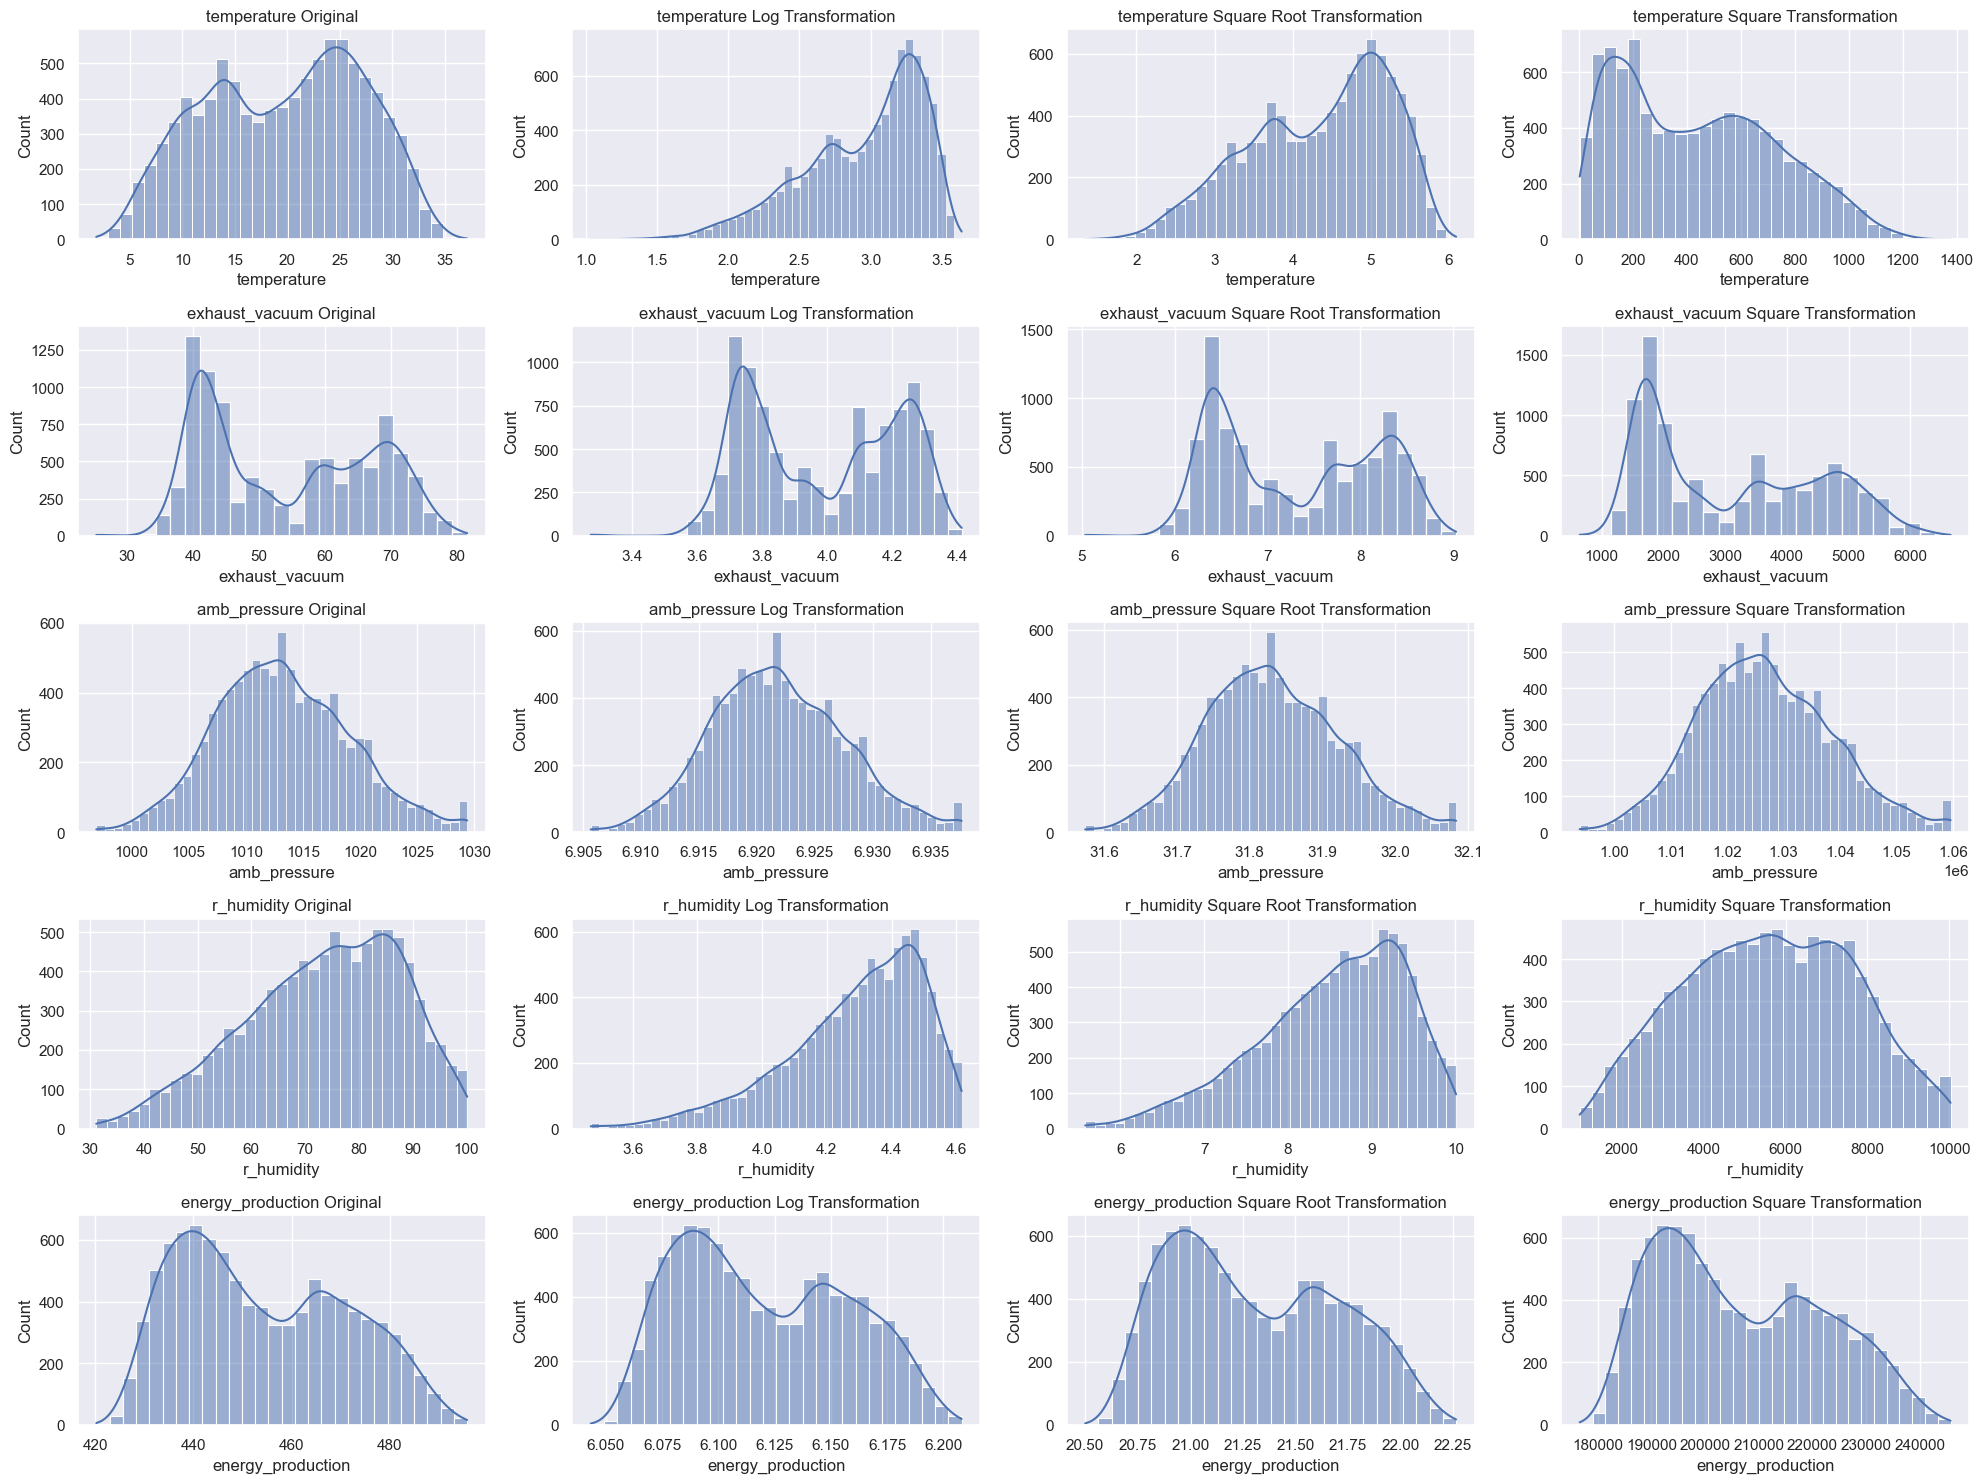

In [22]:

def plot_transformations(df):
    
    transformed_df = pd.DataFrame(index=df.index)

  
    fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))

    for i, col in enumerate(df.columns):
       
        sns.histplot(df[col], kde=True, ax=ax[i, 0])
        ax[i, 0].set_title(f"{col} Original")

        
        log_transformed = np.log1p(df[col])
        transformed_df[f"{col}_log"] = log_transformed
        sns.histplot(log_transformed, kde=True, ax=ax[i, 1])
        ax[i, 1].set_title(f"{col} Log Transformation")

    
        sqrt_transformed = np.sqrt(df[col])
        transformed_df[f"{col}_sqrt"] = sqrt_transformed
        sns.histplot(sqrt_transformed, kde=True, ax=ax[i, 2])
        ax[i, 2].set_title(f"{col} Square Root Transformation")

        
        square_transformed = np.square(df[col])
        transformed_df[f"{col}_square"] = square_transformed
        sns.histplot(square_transformed, kde=True, ax=ax[i, 3])
        ax[i, 3].set_title(f"{col} Square Transformation")



    plt.tight_layout()
    return transformed_df


transformed_data = plot_transformations(df)
plt.show()


from this we can see that
- temperature column does not require any transformation
- exhaust_vaccum column we can use log transform
- amb_pressure no transformation 
- r_humidiy square transformation can be applied
- energy_prduction no transformation required

In [23]:
def log_transform(X):
    X["exhaust_vacuum"] = np.log1p(X['exhaust_vacuum'])
    return X

def square_transform(X):
    X['r_humidity'] = np.square(X['r_humidity']) 
    return X

In [24]:
df = log_transform(df)
df = square_transform(df)

# `MODEL BUILDING AND EVALUATING ON DATASE AFTER FEATURE ENGINEERING`

In [25]:
X1 = df.drop("energy_production", axis = 1)
y1 = df['energy_production']

In [26]:
results1 = evaluate_regression_models(X1, y1, models=models_to_evaluate)
results1

Standard Scaler                                         \
                         R2 Score Mean Absolute Error Mean Squared Error   
Linear Regression          0.9301            3.603058          20.423527   
Ridge Regression         0.930097            3.603202          20.424335   
Lasso Regression           0.9146            3.989335           24.95235   
Random Forest            0.962026            2.366679          11.095251   
SVR                      0.941962            3.118705          16.957536   
XGBoost                  0.965151            2.266298          10.182354   
Gradient Boosting         0.94832            2.933517          15.099979   

                  Min-Max Scaler                                         \
                        R2 Score Mean Absolute Error Mean Squared Error   
Linear Regression         0.9301            3.603058          20.423527   
Ridge Regression         0.93001            3.606768          20.449762   
Lasso Regression        0.826163            5.850361           50.79208   
Random Forest           0.962043            2.365275          11.090422   
SVR                     0.941531            3.129466          17.083497   
XGBoost                 0.965151            2.266298          10.182354   
Gradient Boosting        0.94832            2.933424          15.099903   

                  Robust Scaler                                         \
                       R2 Score Mean Absolute Error Mean Squared Error   
Linear Regression        0.9301            3.603058          20.423527   
Ridge Regression       0.930093            3.603436          20.425486   
Lasso Regression       0.903796             4.25192          28.108954   
Random Forest           0.96198            2.368874          11.108801   
SVR                    0.941498            3.137896          17.093334   
XGBoost                0.965151            2.266298          10.182354   
Gradient Boosting      0.948316            2.933791             15.101   

                  Standard Scaler  Min-Max Scaler   Robust Scaler  
                  Cross-Val Score Cross-Val Score Cross-Val Score  
Linear Regression       20.862788       20.862788       20.862788  
Ridge Regression        20.862810       20.878054       20.862951  
Lasso Regression        25.009617       49.723628       28.028941  
Random Forest           12.133341       12.129965       12.137146  
SVR                     17.945782       18.027658       18.087021  
XGBoost                 11.510384       11.510384       11.510384  
Gradient Boosting       15.244111       15.246163       15.245461

In [27]:
results

Standard Scaler                                         \
                         R2 Score Mean Absolute Error Mean Squared Error   
Linear Regression        0.929727             3.62022          20.532645   
Ridge Regression         0.929724            3.620379          20.533353   
Lasso Regression         0.913066            4.030631          25.400646   
Random Forest            0.962027            2.366385          11.095042   
SVR                      0.941443            3.132721          17.109352   
XGBoost                  0.966352            2.220298           9.831395   
Gradient Boosting        0.948092            2.942359          15.166539   

                  Min-Max Scaler                                         \
                        R2 Score Mean Absolute Error Mean Squared Error   
Linear Regression       0.929727             3.62022          20.532645   
Ridge Regression        0.929636            3.624191          20.559165   
Lasso Regression        0.833213             5.69356          48.732193   
Random Forest           0.961993            2.367305          11.105106   
SVR                     0.941533            3.123171          17.083087   
XGBoost                 0.966352            2.220298           9.831395   
Gradient Boosting       0.948092            2.942359          15.166539   

                  Robust Scaler                                         \
                       R2 Score Mean Absolute Error Mean Squared Error   
Linear Regression      0.929727             3.62022          20.532645   
Ridge Regression        0.92972            3.620631          20.534432   
Lasso Regression         0.9028            4.278387          28.400215   
Random Forest          0.961969            2.369054          11.111955   
SVR                    0.940693            3.159653          17.328479   
XGBoost                0.966352            2.220298           9.831395   
Gradient Boosting      0.948089            2.942673           15.16754   

                  Standard Scaler  Min-Max Scaler   Robust Scaler  
                  Cross-Val Score Cross-Val Score Cross-Val Score  
Linear Regression       20.940177       20.940177       20.940177  
Ridge Regression        20.940197       20.957858       20.940349  
Lasso Regression        25.384521       47.703851       28.302391  
Random Forest           12.129667       12.128189       12.134333  
SVR                     17.999058       17.962312       18.165066  
XGBoost                 11.302267       11.302267       11.302267  
Gradient Boosting       15.194778       15.192945       15.192164

after comapring the results of different algorithmn and comaprig the results after before and after  transformation we found that 
-  the results are slightly improved  after transformation

- scaling has no significant effect on the results.

- among all the algorithms Xgboost and RandomForest performed well

# `HYPERPARAMETER TUNING`

now we will try hyperparameter tuning on xgBoost

In [28]:
from sklearn.model_selection import GridSearchCV 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
sc = StandardScaler() 
scaled_train = sc.fit_transform(X_train)
scaled_test = sc.transform(X_test)

In [31]:
xg_reg = XGBRegressor(objective ='reg:squarederror', seed = 42)

In [32]:
param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'alpha': [1, 5, 10]
}

In [33]:
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid,
                           scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(scaled_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'alpha': [1, 5, 10], 'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.1, 0.01], 'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_absolute_error')

In [34]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [35]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(scaled_test)

In [36]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')

Mean Squared Error on Test Set: 11.677438754095267


In [37]:
models_to_evaluate = {
    'XGBoost': XGBRegressor(objective='reg:squarederror', seed=42,
                           alpha = 10,colsample_bytree= 0.7,learning_rate = 0.1,
                           max_depth= 7, n_estimators= 200),
    
}

In [38]:
results3 = evaluate_regression_models(X, y, models=models_to_evaluate)

In [39]:
results3

Standard Scaler                                        Min-Max Scaler  \
               R2 Score Mean Absolute Error Mean Squared Error       R2 Score   
XGBoost        0.960034            2.506192          11.677439       0.960034   

                                               Robust Scaler  \
        Mean Absolute Error Mean Squared Error      R2 Score   
XGBoost            2.506192          11.677439      0.960034   

                                               Standard Scaler  \
        Mean Absolute Error Mean Squared Error Cross-Val Score   
XGBoost            2.506192          11.677439       12.631002   

         Min-Max Scaler   Robust Scaler  
        Cross-Val Score Cross-Val Score  
XGBoost       12.631002       12.631002

# `FINAL MODEL BUILDING IN PIPELINE`

In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [41]:
final_df = power.copy()

In [42]:
final_df = final_df.drop_duplicates()

In [43]:
def preprosessor(frame):
    
    for i in frame.columns:
        q3 = np.percentile(frame[i], 75)
        q1 = np.percentile(frame[i], 25)

        iqr = q3 - q1 

        upper = q3 + 1.5 * iqr
        lower = q1 - 1.5 * iqr

    frame[i] = np.where(frame[i] > upper, upper, np.where(frame[i] < lower, lower, frame[i]))

    frame["exhaust_vacuum"] = np.log1p(frame['exhaust_vacuum'])

    frame['r_humidity'] = np.square(frame['r_humidity']) 
        
    return frame
   

In [44]:
preprosessor(final_df)

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
0,9.59,3.677819,1017.01,3612.0100,481.30
1,12.04,3.769076,1019.72,8962.4089,465.36
2,13.87,3.830379,1024.42,6673.2561,465.48
3,13.72,4.012773,1017.89,6253.6464,467.05
4,15.14,3.924742,1023.78,5625.0000,463.58
...,...,...,...,...,...
9563,17.10,3.925729,1005.53,6694.5124,457.32
9564,24.73,4.194793,1015.42,2787.8400,446.92
9565,30.44,4.047253,1005.19,3162.9376,429.34
9566,23.00,4.205439,1020.61,6446.4841,421.57


In [45]:
preprocessor_step = FunctionTransformer(preprosessor, validate=False)

In [46]:
xgb_model = XGBRegressor(objective='reg:squarederror', seed=42,
                           alpha = 10,colsample_bytree= 0.7,learning_rate = 0.1,
                           max_depth= 7, n_estimators= 200)

In [47]:
X_final = final_df.iloc[:,:-1]
y_final = final_df.iloc[:,-1]

In [48]:
X_train, X_test, y_train, y_test =train_test_split(X_final, y_final,test_size=0.3, random_state=42)

In [49]:
pipe = Pipeline([
    ('preprocessor',preprocessor_step),
    ('Scaling', StandardScaler()),
    ('model', xgb_model)    
])

In [50]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 FunctionTransformer(func=<function preprosessor at 0x00000169F1804A40>)),
                ('Scaling', StandardScaler()),
                ('model',
                 XGBRegressor(alpha=10, base_score=None, booster=None,
                              callbacks=None, colsample_bylevel=None,
                              colsample_bynode=None, colsample_bytree=0.7,
                              device=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [51]:
r2_score(pipe.predict(X_test), y_test)

0.9570215795079848

In [52]:
import pickle

In [53]:
pickle.dump(pipe, open("model_pipe.pkl","wb"))

In [54]:
pickle.dump(preprosessor, open("preprocessor.pkl","wb"))